In [1]:
# Import Packages
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import geopandas as gpd

In [2]:
# you may change the file name to your own file name
gdf_Miami = gpd.read_file("df_Miami_grid_2000.geojson")
gdf_Miami.head()

,ID,shape_area_km2,latitude,longitude,PP,OP,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,...,Education,Finance & Professional Services,Food & Beverage,Healthcare,Others,Public Services & Infrastructure,Recreation & Leisure,Retail,Transportation,geometry
0,2,4.0,25.452871,-80.539352,9.191377,0.025079,10.912722,0.360751,10.101032,13.528167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-80.52944 25.44381, -80.52937 25.461..."
1,3,4.0,25.470931,-80.539283,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-80.52937 25.46187, -80.5293 25.4799..."
2,4,4.0,25.488991,-80.539214,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-80.5293 25.47993, -80.52923 25.4979..."
3,5,4.0,25.507052,-80.539146,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-80.52923 25.49799, -80.52916 25.516..."
4,6,4.0,25.525112,-80.539077,9.191377,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,"POLYGON ((-80.52916 25.51605, -80.52909 25.534..."


<Axes: >

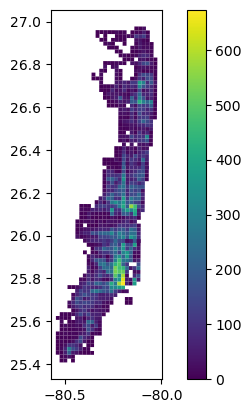

In [3]:
gdf_Miami.plot(column='All_crash', cmap='viridis', legend=True)

## Model train and test

In [4]:
from sklearn.model_selection import train_test_split

selected_columns = ['PP', 'EP_NOVEH', 'EP_POV150', 'EP_CROWD', 'EP_LIMENG',
                    'sample_count', 
                    'Car_median', 'Person_q25', 'Sidewalk_q75', 'Fence_q25', 'Terrain_q25',
                    ]

X = gdf_Miami[selected_columns]
y = gdf_Miami['All_crash']

X_train, X_test, y_train, y_test, train_idx, test_idx, train_coords, test_coords = train_test_split(X, y, gdf_Miami.index, gdf_Miami[['longitude', 'latitude']], test_size=0.3, random_state=28)

# MGRF modeling

In [17]:
import PyMGRF

# Multiscale Geographical Random Forest (MGRF)
# should: band_width > n_estimators, global_n_estimators>local_n_estimators>30
model = PyMGRF.PyMGRFBuilder(global_n_estimators=32, local_n_estimators=70, max_features=1/3, 
                             band_width_min=30, band_width_max=140, target = "R2", num = 12, kernel= "adaptive", 
                             train_weighted=True, predict_weighted=True, resampled=True, random_state=28)

## Fixed bandwidth Geographical Random Forest (GRF)

# model = PyMGRF.PyMGRFBuilder(global_n_estimators=32, local_n_estimators=70, max_features=1/3, 
#                              band_width_min=30, band_width_max=30, target = "R2", num = 1, kernel= "adaptive",
#                              train_weighted=True, predict_weighted=True, resampled=True, random_state=28)

In [18]:
## Model fitting
global_oob_prediction, local_oob_prediction = model.fit(X_train, y_train, train_coords)
print("Fitting OK!")

Fitting OK!


In [ ]:
## Model predict
predict_combined, predict_global, predict_local = model.predict(X_test, test_coords, local_weight=0.8)
print("Test OK!")
predict_local = np.array(predict_local)
predict_global = np.array(predict_global)

Test OK!


1592.791840724633
27.08382402832972
0.846228301959558


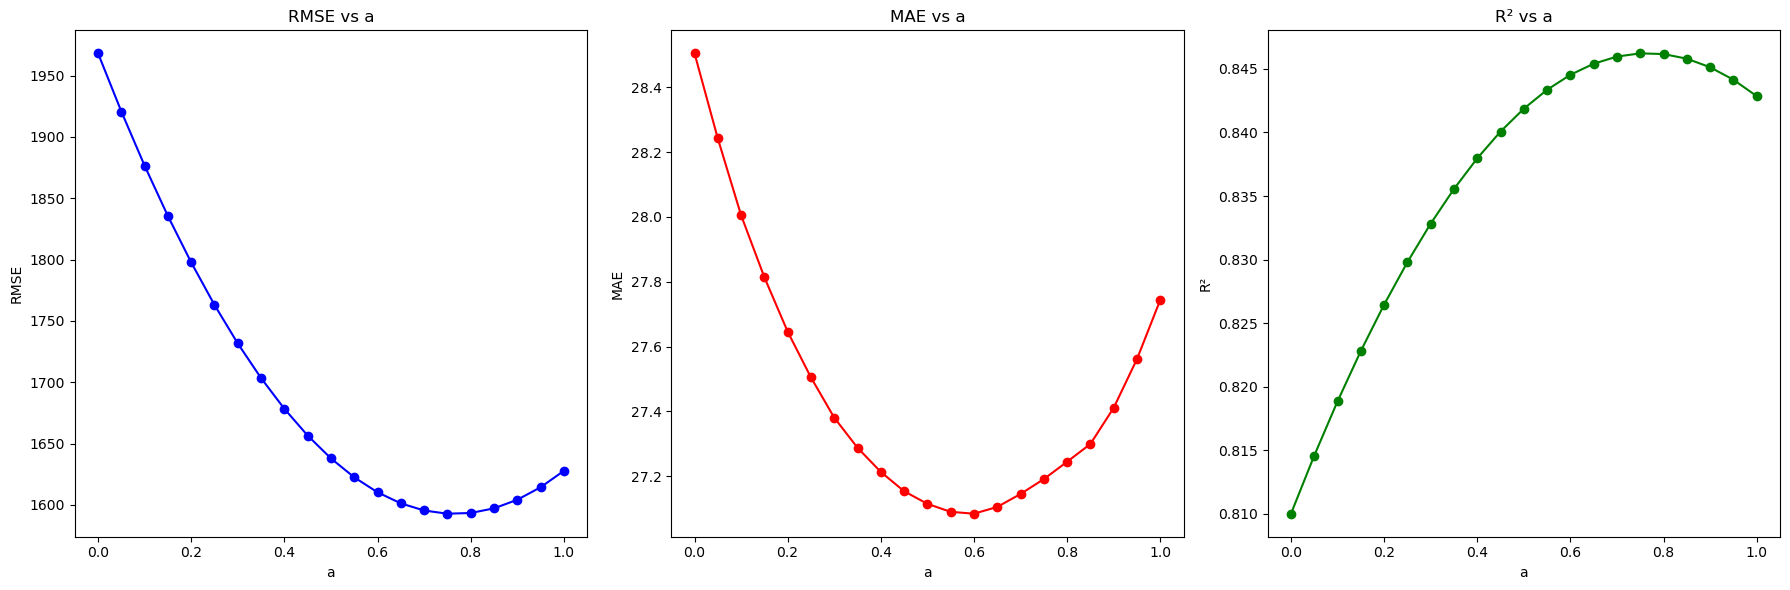

In [20]:
# [30, 140, 10]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

a_values = np.arange(0, 1.05, 0.05)

mae_values = []
rmse_values = []
r2_values = []

for a in a_values:
    weighted_prediction = a * predict_local + (1 - a) * predict_global
    
    rmse = mean_squared_error(y_test, weighted_prediction)
    rmse_values.append(rmse)
    
    r2 = r2_score(y_test, weighted_prediction)
    r2_values.append(r2)
    
    mae = mean_absolute_error(y_test, weighted_prediction)
    mae_values.append(mae)

print(np.min(rmse_values))
print(np.min(mae_values))
print(np.max(r2_values))
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(a_values, rmse_values, marker='o', color='blue')
plt.title('RMSE vs a')
plt.xlabel('a')
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
plt.plot(a_values, mae_values, marker='o', color='red')
plt.title('MAE vs a')
plt.xlabel('a')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.plot(a_values, r2_values, marker='o', color='green')
plt.title('R² vs a')
plt.xlabel('a')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


## Model evaluation

In [21]:
import PyMGRF
# should: band_width > n_estimators, global_n_estimators>local_n_estimators>30
model = PyMGRF.PyMGRFBuilder(global_n_estimators=32, local_n_estimators=16, max_features=1/3, 
                             band_width_min=30, band_width_max=140, target = "R2", num = 22, kernel= "adaptive",
                             train_weighted=True, predict_weighted=True, resampled=True, random_state=28)

selected_columns = ['PP', 'EP_NOVEH', 'EP_POV150', 'EP_CROWD', 'EP_LIMENG',
                    'sample_count', 'Car_median', 'Person_q25', 'Sidewalk_q75', 'Fence_q25', 'Terrain_q25']

global_oob_prediction, local_oob_prediction = model.fit(gdf_Miami[selected_columns], gdf_Miami['All_crash'], gdf_Miami[['longitude', 'latitude']])

## Local R2

In [22]:
from sklearn.metrics import r2_score
import numpy as np

global_oob_r2 = r2_score(gdf_Miami['All_crash'], global_oob_prediction)
print(f"Global model OOB R² value：{global_oob_r2}")

local_oob_prediction = np.array(local_oob_prediction)
local_oob_r2 = r2_score(gdf_Miami['All_crash'], local_oob_prediction)
print(f"Local model OOB R² value：{local_oob_r2}")

Global model OOB R² value：0.7478477842775701
Local model OOB R² value：0.7565146358603008


In [23]:
gdf_Miami['Local_R2'] = model.local_r2_scores
gdf_Miami['Local_BW'] = model.local_bandwidths

### Global importance

In [24]:
global_fi = model.global_model.feature_importances_
df_global_fi = pd.DataFrame(global_fi.reshape(1, -1), columns=selected_columns)

### Local importance

In [27]:
local_fi = model.get_local_feature_importance()
df_local_fi = pd.DataFrame(local_fi).rename(columns=lambda x: x + '_gdf').drop(columns=['model_index_gdf'])
gdf_modeling_results = pd.concat([gdf_Miami.reset_index(drop=True), df_local_fi], axis = 1)
gdf_modeling_results = gpd.GeoDataFrame(gdf_modeling_results, geometry=gdf_Miami.reset_index(drop=True).geometry)
gdf_modeling_results['Highest_feature'] = gdf_modeling_results[df_local_fi.columns].idxmax(axis=1)

gdf_modeling_results.head()

/Users/cpf/Library/CloudStorage/OneDrive-Personal/Sync_All/All_Code/Code/MGRF_codes/PyMGRF.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


,ID,shape_area_km2,latitude,longitude,PP,OP,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,...,EP_POV150_gdf,EP_CROWD_gdf,EP_LIMENG_gdf,sample_count_gdf,Car_median_gdf,Person_q25_gdf,Sidewalk_q75_gdf,Fence_q25_gdf,Terrain_q25_gdf,Highest_feature
0,2,4.0,25.452871,-80.539352,9.191377,0.025079,10.912722,0.360751,10.101032,13.528167,...,0.025215,0.048514,0.054779,0.080241,0.162998,0.033889,0.311373,0.024038,0.030733,Sidewalk_q75_gdf
1,3,4.0,25.470931,-80.539283,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.008886,0.013146,0.068610,0.042161,0.238782,0.002191,0.341378,0.019178,0.067985,Sidewalk_q75_gdf
2,4,4.0,25.488991,-80.539214,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.019108,0.010077,0.026139,0.004138,0.117339,0.042089,0.439189,0.004905,0.035695,Sidewalk_q75_gdf
3,5,4.0,25.507052,-80.539146,9.191378,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.063108,0.018235,0.025520,0.061040,0.145841,0.002989,0.427953,0.002760,0.062572,Sidewalk_q75_gdf
4,6,4.0,25.525112,-80.539077,9.191377,0.025079,10.912722,0.360751,10.101032,13.528168,...,0.173427,0.056739,0.014576,0.059493,0.159507,0.033845,0.213342,0.010673,0.071195,Sidewalk_q75_gdf


In [28]:
mean_values = df_local_fi.mean()
var_values = df_local_fi.std()
max_values = df_local_fi.max()
min_values = df_local_fi.min()

summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Variance': var_values,
    'Max': max_values,
    'Min': min_values
})
summary_stats.sort_values(by='Mean', ascending=False)

,Mean,Variance,Max,Min
Car_median_gdf,0.148607,0.068433,0.352615,0.007893
sample_count_gdf,0.139952,0.060804,0.334947,0.004138
PP_gdf,0.121849,0.042737,0.291618,0.008664
EP_POV150_gdf,0.114079,0.058328,0.328211,0.002978
EP_NOVEH_gdf,0.088057,0.056435,0.302663,0.005003
Sidewalk_q75_gdf,0.078308,0.070682,0.477305,0.001697
Terrain_q25_gdf,0.073383,0.031790,0.215123,0.005998
Person_q25_gdf,0.071629,0.059708,0.362340,0.000000
EP_CROWD_gdf,0.063150,0.038645,0.271073,0.001982
EP_LIMENG_gdf,0.061735,0.034640,0.203501,0.001375


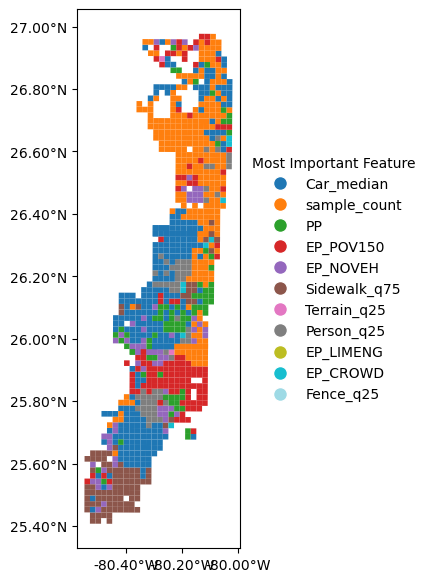

In [ ]:
# unique_features = gdf_modeling_results['Highest_feature'].unique()

unique_features = [
    'Car_median_gdf', 'sample_count_gdf', 'PP_gdf', 'EP_POV150_gdf',
    'EP_NOVEH_gdf', 'Sidewalk_q75_gdf', 'Terrain_q25_gdf', 'Person_q25_gdf', 'EP_LIMENG_gdf',
    'EP_CROWD_gdf', 'Fence_q25_gdf'
]

colormap = plt.get_cmap('tab20', len(unique_features)) 

feature_color_mapping = {feature: colormap(i) for i, feature in enumerate(unique_features)}

gdf_modeling_results['color'] = gdf_modeling_results['Highest_feature'].map(feature_color_mapping)

fig, ax = plt.subplots(figsize=(5, 7))

gdf_modeling_results.plot(ax=ax, color=gdf_modeling_results['color'])

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=feature_color_mapping[feature], markersize=10)
           for feature in unique_features]
labels = [
    'Car_median', 'sample_count', 'PP', 'EP_POV150',
    'EP_NOVEH', 'Sidewalk_q75', 'Terrain_q25', 'Person_q25', 'EP_LIMENG',
    'EP_CROWD', 'Fence_q25'
]

ax.legend(handles, labels, title="Most Important Feature", loc='center left', 
          frameon = False,
          bbox_to_anchor=(1, 0.5))

ax.tick_params(axis='both', which='major', labelsize=10)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:.2f}°N'))

plt.show()

## Spatial Distribution of Feature Importance

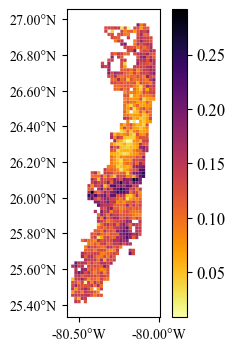

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

colors = [
    # "#104682",
    # "#31817b",
    # "#6d89ad",
    # "#b6cdd7",
    "#e9f1f4",
    "#fbddd9",
    "#f6b282",
    "#de6d57",
    "#b72233"
]

colors = ['#fef0d9', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000']

my_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=265)

fig, ax = plt.subplots(1,1, figsize=(3,4))

selected_feature = 'PP_gdf'

gdf_modeling_results.plot(ax=ax, column = selected_feature, 
                  cmap='inferno_r',
                  legend=True)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:.2f}°N'))

plt.show()

In [31]:
global_model, local_models = model.get_models()

In [32]:
# Feature importance
global_feature_importances = global_model.feature_importances_
print("Global feature importance：", global_feature_importances)

# Model parameters
print("Global model parameters", global_model.get_params())

Global feature importance： [0.21708204 0.06583784 0.0974585  0.03855636 0.03181926 0.13958263
 0.13212044 0.10594258 0.03937491 0.03853927 0.09368617]
Global model parameters {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.3333333333333333, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': None, 'oob_score': True, 'random_state': 28, 'verbose': 0, 'warm_start': False}


In [34]:
# Show first local model
first_local_model = local_models[0]
print("First local model：", first_local_model)

# Feature importance of first local model
first_local_feature_importances = first_local_model.feature_importances_
print("Feature importance of first local model：", first_local_feature_importances)

for idx, model in enumerate(local_models):
    print(f"Feature importance of local model: {idx}", model.feature_importances_)

First local model： RandomForestRegressor(max_features=0.3333333333333333, n_estimators=16,
                      oob_score=True, random_state=28)
Feature importance of first local model： [0.13895082 0.08927049 0.02521485 0.04851401 0.05477876 0.08024108
 0.16299769 0.03388895 0.31137272 0.02403759 0.03073304]
Feature importance of local model: 0 [0.13895082 0.08927049 0.02521485 0.04851401 0.05477876 0.08024108
 0.16299769 0.03388895 0.31137272 0.02403759 0.03073304]
Feature importance of local model: 1 [0.07065854 0.12702566 0.00888585 0.01314564 0.06860984 0.04216148
 0.23878192 0.00219104 0.34137783 0.01917756 0.06798465]
Feature importance of local model: 2 [0.14992394 0.15139767 0.01910786 0.01007732 0.02613883 0.00413839
 0.11733866 0.04208857 0.43918872 0.00490458 0.03569547]
Feature importance of local model: 3 [0.1275252  0.06245577 0.0631078  0.01823502 0.02552046 0.06104023
 0.14584126 0.00298948 0.4279529  0.00275983 0.06257203]
Feature importance of local model: 4 [0.12639

# SHAP

## Global SHAP

In [35]:
import shap
import matplotlib.pyplot as plt

In [36]:
# Creating a SHAP interpreter
explainer = shap.TreeExplainer(global_model)
shap_values = explainer.shap_values(gdf_Miami[selected_columns])

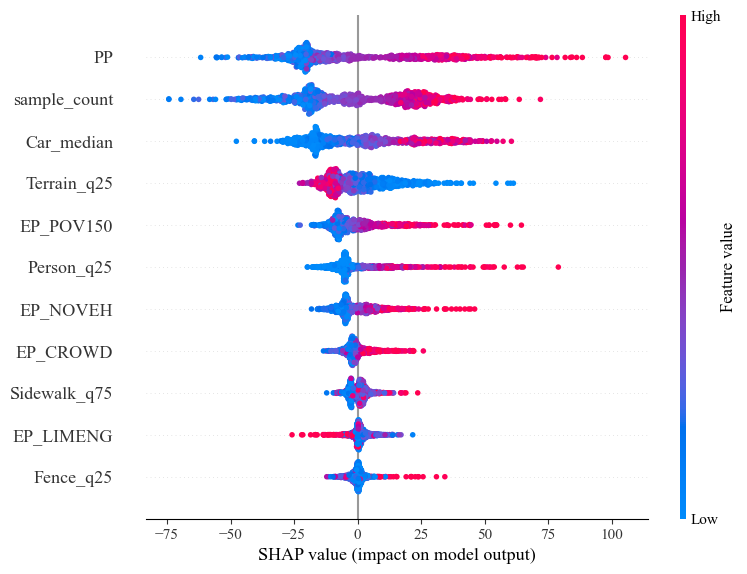

In [38]:
# Plot SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, gdf_Miami[selected_columns], show=False)
plt.tight_layout()
plt.show()

## Spatial Distribution of SHAP values

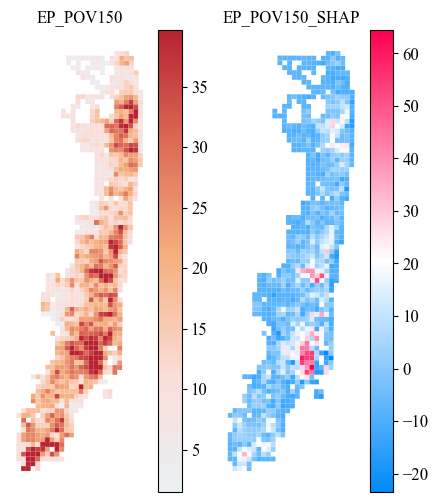

In [ ]:
fig, axes = plt.subplots(1,2 , figsize=(5,6))

i = 2

ax = axes[0]

colors = [
    # "#104682",
    # "#31817b",
    # "#6d89ad",
    # "#b6cdd7",
    "#e9f1f4",
    "#fbddd9",
    "#f6b282",
    "#de6d57",
    "#b72233"
]
my_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=265)


gdf_Miami.plot(ax=ax, column = selected_columns[i], 
                  vmax = np.percentile(gdf_Miami[selected_columns[i]], 95),
                  cmap=my_cmap, legend=True)

ax.set_title(f"{gdf_Miami[selected_columns].columns[i]}", fontsize=12)

ax.axis('off')
ax = axes[1]

colors = [
    # "#104682",
    "#31817b",
    "#6d89ad",
    "#b6cdd7",
    "#e9f1f4",
    "#fbddd9",
    "#f6b282",
    "#de6d57",
    "#b72233"
]

my_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=265)


gdf_Miami.plot(ax=ax, column = shap_values[:,i], cmap=shap.plots.colors.red_white_blue, legend=True)

ax.set_title(f"{gdf_Miami[selected_columns].columns[i]}_SHAP", fontsize=12)


ax.axis('off')

plt.show()

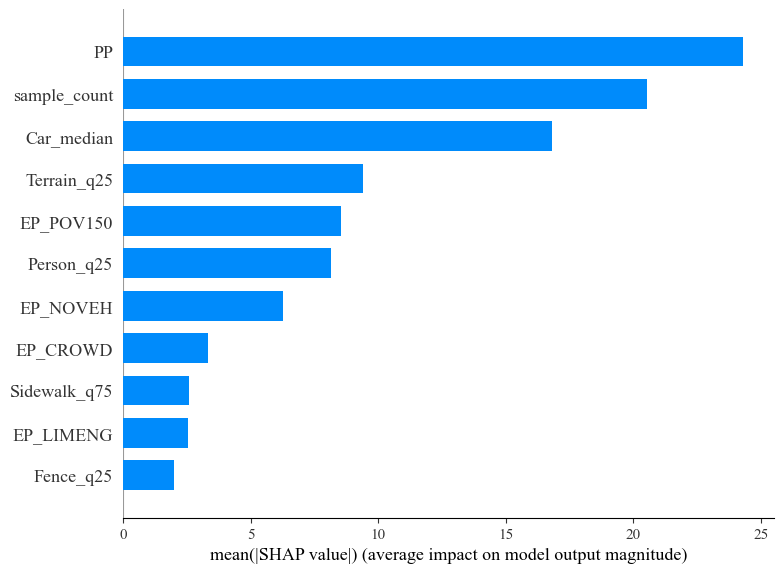

In [ ]:
# Mapping the impact of features
shap.summary_plot(shap_values, gdf_Miami[selected_columns], plot_type="bar")

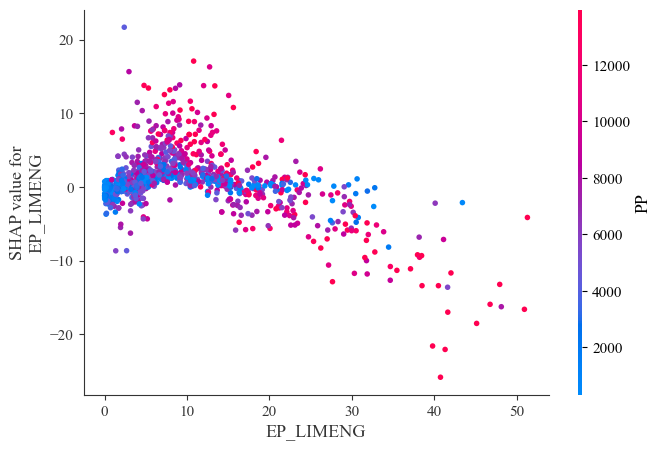

In [ ]:
# Plotting Features of SHAP Values
feature_name = 'EP_LIMENG'  # Replace with your feature name
shap.dependence_plot(feature_name, shap_values, gdf_Miami[selected_columns])

In [42]:
# High crash risk region
index = gdf_Miami[gdf_Miami['ID'] == 545].index  # Sample index
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values[index], gdf_Miami[selected_columns].iloc[index])
force_plot

In [43]:
# Low crash risk region
index = gdf_Miami[gdf_Miami['ID'] == 889].index  # Sample index
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values[index], gdf_Miami[selected_columns].iloc[index])
force_plot